In this script, I try to use RL to solve the knapsack problem.
This should not be an exciting project but just a warm up (for me at least) to understand hands-on RL, RNN, embeddings and such.

The project starts with:
- a nn to move from 2 features per object to 8
- a LTSM with an internal state composed by 5 features
- its output is fed to a fully connected layer that from 5 feature expands to the number of objects
- a softmax decides which element to choose
- If you chose objects whose weight is more than 1, the reward is -100
- attention mechanism with glimpse

Still to implement:
- mask to not choose 'wrong' objects
- for now, it works only wwith batches of one. Cahnge this

As always, we start by importing useful libraries and defiening some boundary conditions

In [23]:
import matplotlib.pyplot as plt

import numpy as np 
import pandas as pd
import torch 
import random
import itertools    

%matplotlib inline

random.seed(1234)
prize_min = 1
prize_max = 10

Then we define the object class

In [24]:
class ObjectCass:
    
    Prize = None
    Weight = None
    
    def __init__(self, reward, weight):
        
        self.Prize = reward
        self.Weight = weight

Now we define the function to generate new instances.

In [25]:
def GenerateANewInstance(num_objs):
    
    # fake code to control the instance I fed it.
    # best solution = [1,0,1,0,1,0,1,0,1,0,1]
    
    Objects = []
    for i in range(num_objs):
        prize = round(random.uniform(prize_min, prize_max), 0)
        weight = round(random.uniform(0.01, 1), 2)
        obj = ObjectCass(prize,weight)
        Objects.append(obj)
    Objects.append(ObjectCass(0,0)) # fake object representing that you don't pick up anything
    
    # real code    
    
    Objects = []
    for i in range(num_objs):
        prize = round(random.uniform(prize_min, prize_max), 0)
        weight = round(random.uniform(0.01, 1), 2)
        obj = ObjectCass(prize,weight)
        Objects.append(obj)
    Objects.append(ObjectCass(0,0)) # fake object representing that you don't pick up anything
                                   # i.e. you stop picking up stuff
    
    return Objects

Now we define a very general agent --  NOT USED!!

In [26]:
class AgentClass:
    def __init__(self):
        self.total_reward = 0.0

    def step(self, env):
        
        current_obs = env.get_observation() #this could be rmeoved I think
        actions = env.get_actions()
        reward = env.action(random.choice(actions))
        self.total_reward += reward
        
        return action
Agent = AgentClass()

Now I try to create a shallow NN. from the features of the input (which are 2), I want to output 10 features (whith one hidden layer of size 10 as well).

In [27]:
#class EmbeddingPlusLSTM(torch.nn.Module):
#    
#    def __init__(self, num_input, num_embeddings, num_h, num_output, batch_size):    
#        
#        super(EmbeddingPlusLSTM, self).__init__() # this is not really clear to me
#        
#        self.fc1 = torch.nn.Linear(num_input, num_embeddings)
#        self.fc2 = torch.nn.Linear(num_embeddings, num_embeddings)
#        self.lstm= torch.nn.LSTM(num_embeddings,  num_h)
#        self.fc3 = torch.nn.Linear(num_h, num_output)
#        
#        # here I set the first internal state of the RNN.
#        # I set it here and not in forwards otherwise it start with different h_0
#        # For now it's zero-initialied, but maybe there is something smarter 
#        # that can be done.
#        
#        self.batch_size = batch_size 
#        n_layers = 1                
#        self.hidden_state = torch.zeros(n_layers, self.batch_size, self.fc3.in_features)
#        self.cell_state = torch.zeros(n_layers, self.batch_size, self.fc3.in_features)
#            
#    def forward(self, x):
#        
#        self.hidden = (self.hidden_state, self.cell_state)
#        x = self.fc1(x)
#        x = self.fc2(x)
#        
#        x = x[None, :, :] # I don't know why you have to add a dimension here
#        
#        self.hidden, cell_state = self.lstm(x, self.hidden)
#        x = self.fc3(self.hidden)  
#        x = torch.nn.functional.softmax(x, dim = 1)
#        
#        return x

In [28]:
#tensors = torch.tensor([[1., -1.],[2., 15.],[1., -1.],[20., 12.],[1., -1.],[20., 12.],[1., -1.],[20., 12.]])
#Net = EmbeddingPlusLSTM(2, 8, 5, 10, len(tensors)) 
## 2 is the number of features of an Object
## 8 is the number of features for the embedding
## 5 number of features for the hidden size of the rnn
##10 is the number of output features
## the last one is the batch size
#
#print('number of parameters: ', sum(p.numel() for p in Net.parameters() if p.requires_grad))

Here we define the parameters of the actor network and we create it. We also take a look at the number of trainable variables.

In [29]:
class RNN_Attention(torch.nn.Module):
    
    def __init__(self, num_input_features, dim_kernel, num_embeddings, num_h, dim_W_a, dim_W_c, batch_size):    
        
        super(RNN_Attention, self).__init__() # this is not really clear to me
        
        self.cnn_embedding = torch.nn.Conv1d(num_input_features, num_embeddings, dim_kernel) # in channel, out channel, kernel size
        print('still to decide the kernel size')
        print('and how do you set the number of filters to D?')
        print('so far I set the number of groups to num_input_features')
        print('doing so, each input featur has its own set of filters (see documentation)')
        self.lstm= torch.nn.LSTM(num_embeddings,  num_h)        
        self.last_item_embedding = torch.nn.Linear(num_input_features,  num_embeddings)        
        print('also, so far you feed to the LSTM both the static and dinamic info.')
        print('and to match the dimension, you pass this info into a fully connected layer')
        print('you will have to change it, so to feed only the static part')
        self.W_a = torch.tensor(torch.rand(dim_W_a,num_embeddings + num_h), requires_grad=True)
        self.v_a = torch.tensor(torch.rand(dim_W_a), requires_grad=True)
        self.v_a = self.v_a[None, :] # I don't know why you have to add a dimension here
        self.W_c = torch.tensor(torch.rand(dim_W_c, 2*num_embeddings), requires_grad=True)
        self.v_c = torch.tensor(torch.rand(dim_W_c), requires_grad=True)
        self.v_c = self.v_c[None, :] # I don't know why you have to add a dimension here
        # last item defines the last item you selected. 
        # it is initialized as an empty item.
        
        # here I set the first internal state of the RNN.
        # I set it here and not in forwards otherwise it start with different h_0
        # For now it's zero-initialied, but maybe there is something smarter 
        # that can be done.
        
        self.batch_size = batch_size 
        self.num_layers = 1
        self.num_directions = 1
        self.num_h = num_h
        
        print('Xavier Initialization still to do')
        #print('first')
        #print(list(self.W_a))
        #torch.nn.init.xavier_uniform(self.W_a)
        #print('after')
        #print(list(self.W_a))
        #stop
        
    def forward(self, x, last_item):

        # also this is to change (why it does not work if I assign the fucntion directly?)
        ReLU = torch.nn.ReLU()
        # compuitng h_t
        last_item = self.last_item_embedding(torch.tensor([last_item.Prize, last_item.Weight]).float())
        last_item = ReLU(last_item)
        last_item = last_item[None, None, :] # I don't know why you have to add a dimension here
        
        # here it is not clear to me why the batch size has to be one?
        # Maybe because here you pass one info at a time??
        h_0 = torch.zeros( self.num_layers * self.num_directions, 1, self.num_h ) 
        c_0 = torch.zeros( self.num_layers * self.num_directions, 1, self.num_h )
        h_t, cell_t = self.lstm( last_item, (h_0,c_0) )  # if you do not provide the initial cell and state, they are by default zero.

        h_t = torch.squeeze(h_t, dim = 0)    # removing the dimension seq_len since I don't know what it does
        h_t = h_t.t()             # transposing so i have features x samples
        # computing x_bar
        x = x[:, :, None] # I don't know why you have to add a dimension here
        x_bar = self.cnn_embedding(x)
        # concatenation of two tensors
        Concatenations = []
        for x_bar_i in x_bar:
            Concatenations.append(torch.cat((x_bar_i, h_t), 0))
        concatenation_1 = torch.stack(Concatenations, dim = 0)
        concatenation_1 = torch.squeeze(concatenation_1, dim = 2)
        concatenation_1 = concatenation_1.t()
        # computing u_t
        u_t = torch.mm(self.v_a,torch.tanh(torch.mm(self.W_a, concatenation_1))).t()  
        # computing a_t
        a_t = torch.nn.functional.softmax(u_t, dim = 0)        
        # computing the context vector c_t
        C_t_array = []
        index = 0
        for row in x_bar: # apaprently with split you use less grad operations
            C_t_array.append(torch.mul(row, a_t[index]))
            index+=1        
        c_t = torch.stack(C_t_array,dim=0)
        c_t = torch.sum(c_t, dim=0)        
        # concatenation of two tensors
        Concatenations_2 = []
        for x_bar_i in x_bar:
            Concatenations_2.append(torch.cat((x_bar_i, c_t), 0))
        concatenation_2 = torch.stack(Concatenations_2, dim = 0)
        concatenation_2 = torch.squeeze(concatenation_2, dim = 2).t()        
        # computing u_t_tilde
        u_t_tilde = torch.mm(self.v_c,torch.tanh(torch.mm(self.W_c, concatenation_2)))
        # computing actual output
        x = torch.nn.functional.softmax(u_t_tilde, dim = 1)
        x = torch.squeeze(x, dim = 0)

        return x, x_bar

In [30]:
#create an instance
num_objects = 10
Objects = GenerateANewInstance(num_objects)
for obj in Objects:
    if obj.Prize == 0 and obj.Weight == 0:
        last_item = obj


num_input_features = 2 # number of features of an Object
dim_kernel = 1         # kernel dimension (since there are only two features, kerneal dimension = 1)
num_embeddings = 8     # number of features for the embedding
num_h = 5              # number of features for the hidden size of the rnn
dim_W_a = 4            # free dimension of matrix W_a
dim_W_c = 6            # free dimension of matrix W_c
tensors = torch.tensor([[1., -1.],[2., 15.],[1., -1.],[20., 12.]])
#tensors = torch.tensor([[1., -1.]])
Net = RNN_Attention(num_input_features, dim_kernel, num_embeddings, num_h, dim_W_a, dim_W_c, len(tensors))

print('number of parameters: ', sum(p.numel() for p in Net.parameters() if p.requires_grad))
output, x_bar = Net(tensors, last_item)
print(output)

still to decide the kernel size
and how do you set the number of filters to D?
so far I set the number of groups to num_input_features
doing so, each input featur has its own set of filters (see documentation)
also, so far you feed to the LSTM both the static and dinamic info.
and to match the dimension, you pass this info into a fully connected layer
you will have to change it, so to feed only the static part
Xavier Initialization still to do
number of parameters:  348
tensor([0.2971, 0.4035, 0.2971, 0.0024], grad_fn=<SqueezeBackward1>)


/usr/lib/python3/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/lib/python3/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/lib/python3/dist-packages/ipykernel_launcher.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/lib/python3/dist-packages/ipykernel_launcher.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sou

Before implementing the actual RL framework, we need to define the critic network. The critic network takes as input the probabilities of the actor network (after its masking) and the embeddings input (x_bar). These two are multiplied to obtain a weighted sum of the embedded inputs then they are fed into a network with 2 layers. The first layer is dense with ReLU activation and the second one is a linear layer with single output (which is the expected reward). 

In [31]:
class Critic(torch.nn.Module):
    
    def __init__(self, num_input_features, num_inbetween_features):    
        
        super(Critic, self).__init__() # this is not really clear to me
        self.FirstLayer = torch.nn.Linear(num_input_features, num_inbetween_features)
        self.SecondLayer = torch.nn.Linear(num_inbetween_features,  1)        
            
    def forward(self, Average_x_bar):
        
        # change this when you consider batch > 1
        Average_x_bar = torch.squeeze(Average_x_bar)
        ReLU = torch.nn.ReLU()
        #weighted_sum = weighted_sum.squeeze()
        output = self.FirstLayer(Average_x_bar)
        output = ReLU(output)
        output = self.SecondLayer(output)
        
        return output

In [32]:
num_inbetween_features = 16
num_objs = 10
Net_critic = Critic(num_embeddings*(num_objs+1), num_inbetween_features)
print('number of critic parameters: ', sum(p.numel() for p in Net_critic.parameters() if p.requires_grad))

number of critic parameters:  1441


CHANGE LAST_ITEM SUCH THAT IT ALSO EMBEDDS THE REMAINING AVAILABLE CAPACITY
change the mask such that it does not even feed old element to the Net
check again the probability thing.
I don't think it's the probability of the last action but the probability of the whole sequence
THERE IS A FUNCTION CALLED MASK. CHECK IT OUT
check clip value for negative values also
metti Xavier's inizializazione
[-100, -100, -100, -100, -100]


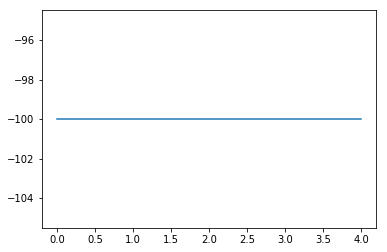

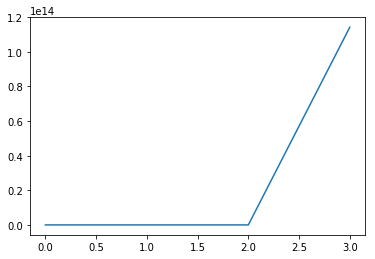

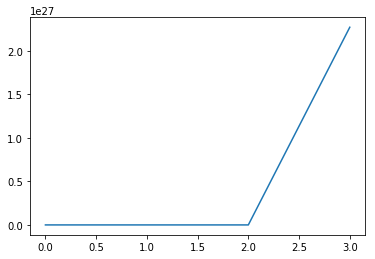

In [34]:
print('CHANGE LAST_ITEM SUCH THAT IT ALSO EMBEDDS THE REMAINING AVAILABLE CAPACITY')
print('change the mask such that it does not even feed old element to the Net')
print('check again the probability thing.')
print('I don\'t think it\'s the probability of the last action but the probability of the whole sequence')
print('THERE IS A FUNCTION CALLED MASK. CHECK IT OUT')
print('check clip value for negative values also')
print('metti Xavier\'s inizializazione')

# define for how many different instances it should run, their size and the number of epochs
num_instances = 1
num_epoch = 1000

# define the loss criterion
criterion = torch.nn.MSELoss()
# create your optimizers
optimizer_actor = torch.optim.SGD(Net.parameters(), lr=0.01)
optimizer_critic = torch.optim.SGD(Net_critic.parameters(), lr=0.01)
Rewards = []
Loss_actor = []
Loss_critic = []

# clipping the gradients
clip_value = 2
torch.nn.utils.clip_grad_value_(Net.parameters(), clip_value)
torch.nn.utils.clip_grad_value_(Net_critic.parameters(), clip_value)

for e_counter in range(num_epoch):
    for i_counter in range(num_instances):
        Objects = GenerateANewInstance(num_objs)
        ObjectsFeatures = torch.tensor([[obj.Prize, obj.Weight] for obj in Objects])
        last_item = Objects[-1]
        Chosen = []
        Outputs = []
        total_reward = 0.0
        total_weight = 0
        total_steps = 0
        while total_steps < num_objs+1:
            total_steps += 1
            output, x_bar = Net(ObjectsFeatures,last_item)
            Outputs.append(output)
            ###################
            # MASK IS MISSING #
            ###################
            # choose action
            action_index = torch.argmax(output)
            # perform action
            total_weight+=Objects[action_index].Weight
            total_reward+=Objects[action_index].Prize
            Chosen.append(Objects[action_index])
            last_item = Objects[action_index]
            if total_weight > 1:
                total_reward = -1
                break
            if last_item.Prize == 0 and last_item.Weight == 0:
                total_reward= -100
                break
        Rewards.append(total_reward)
        #print(Chosen[0].Prize)
        #stop
        
    
    optimizer_actor.zero_grad()   # zero the gradient buffers
    optimizer_critic.zero_grad()  # zero the gradient buffers
    # compute input for critic network
    Outputs = torch.stack((Outputs), dim=0)
    OutputMeans = torch.mean(Outputs,0)
    Averaged_x_bar = []
    for i in range(len(x_bar)):
        Averaged_x_bar.append(x_bar[i]*OutputMeans[i])
    Averaged_x_bar = torch.cat((Averaged_x_bar), dim=0)
    # compute target for critic network
    target = Net_critic(Averaged_x_bar)
    target_tensor = torch.tensor([total_reward], dtype=torch.float32)
    target_tensor.requires_grad = True # I don t understand why this has to be put to true
    # loss critic
    loss_critic = criterion(target, target_tensor)
    loss_critic = loss_critic/num_instances
    loss_critic.backward(retain_graph=True)    
    Loss_critic.append(loss_critic.tolist())
    # loss actor
    loss_actor = (torch.tensor(total_reward) - target)*torch.log(output)
    loss_actor = loss_actor.mean()
    Loss_actor.append(loss_actor.tolist())
    # update actor
    loss_actor.backward()
    optimizer_critic.step()    # Does the update
    optimizer_actor.step()    # Does the update
    #print('iteration number ', e_counter)

R = []
A = []
C = []
for i in range(len(Rewards)):
    if Rewards.index(Rewards[i]) == 0:
        R.append(Rewards[i])
        A.append(Loss_actor[i])
        C.append(Loss_critic[i])
plt.figure()
plt.plot(R)
plt.figure()
plt.plot(A)
plt.figure()
plt.plot(C)
print(R)